# Chen Analysis with scanpy

Use scanpy to analyze kallisto output from alignment of chen data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.2


In [3]:
results_file = 'schen-scrnqseq.h5ad'  # the file that will store the analysis results

Import Data

In [4]:
folder = '/mnt/labshare/ravi/scrna-seq/chen-reanalysis/bus_output/genecount/'

In [5]:
mm10_names = pd.read_table('/home/rmandla/Downloads/mm10_genenames.txt')

In [6]:
scrna_ensembl = pd.read_csv(folder+'gene.genes.txt',header=None)

In [7]:
mm10_names = mm10_names[mm10_names['Gene stable ID version'].isin(scrna_ensembl[0])].drop_duplicates('Gene stable ID version').set_index('Gene stable ID version')

In [8]:
scrna_ensembl = scrna_ensembl.set_index(0)
scrna_ensembl['gene name'] = mm10_names['Gene name']

In [9]:
all_nans = scrna_ensembl[scrna_ensembl['gene name'].isnull()]
all_nans['gene name'] = all_nans.index

<ipython-input-9-35ae948c0ff1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nans['gene name'] = all_nans.index


In [11]:
fixed_scrna = pd.concat([scrna_ensembl.dropna(),all_nans])
fixed_scrna = fixed_scrna.reindex(index = scrna_ensembl.index)

In [12]:
adata = sc.read_mtx(folder + "gene.mtx")
adata.obs.index = pd.read_csv(folder + "gene.barcodes.txt", header=None)[0].values
adata.var.index = fixed_scrna['gene name'].values

Generate Knee plot for filtering

In [13]:
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

/home/rmandla/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


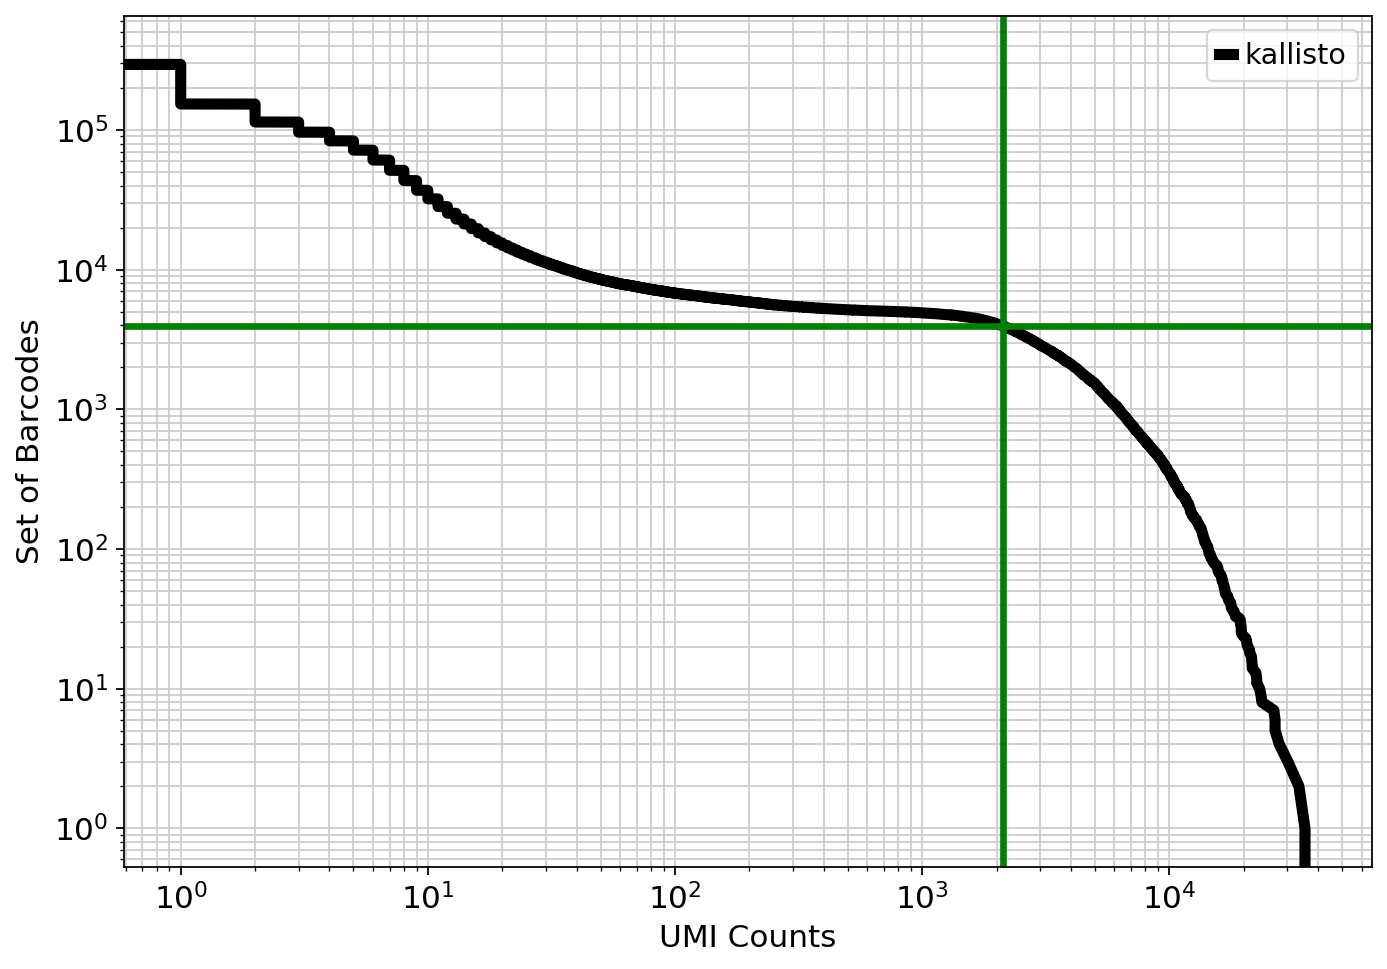

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

expected_num_cells=3949

ax.loglog(knee, range(len(knee)), label="kallisto", linewidth=5, color="k")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="g")
ax.axhline(y=expected_num_cells, linewidth=3, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()
plt.show()

filter from knee plot

In [15]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])
sc.pp.filter_genes(adata, min_cells=0)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 342792 cells that have less than 2124.0 counts


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Generate qc plots (genes per count + total count + counts of mt genes)

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

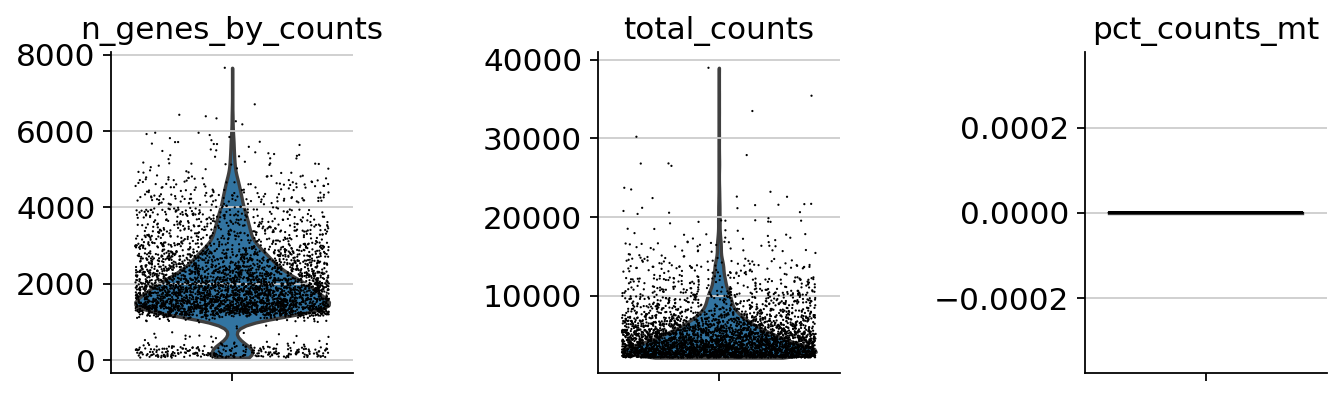

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)



no mitochondrial genes :)

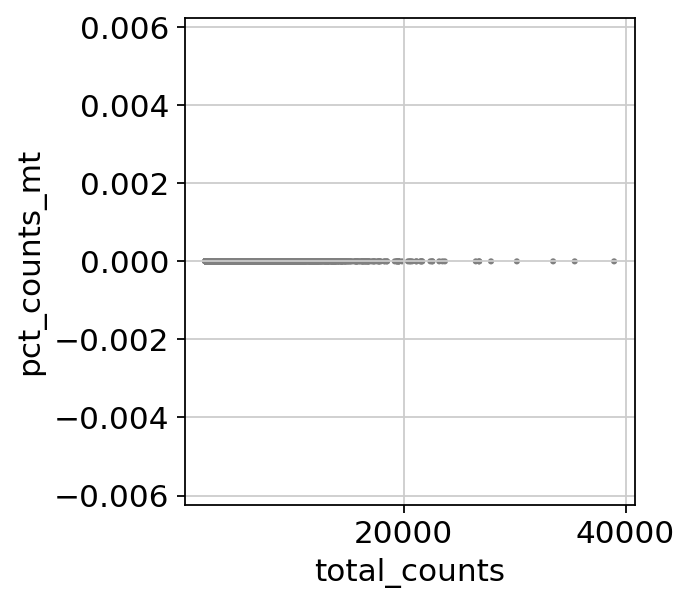

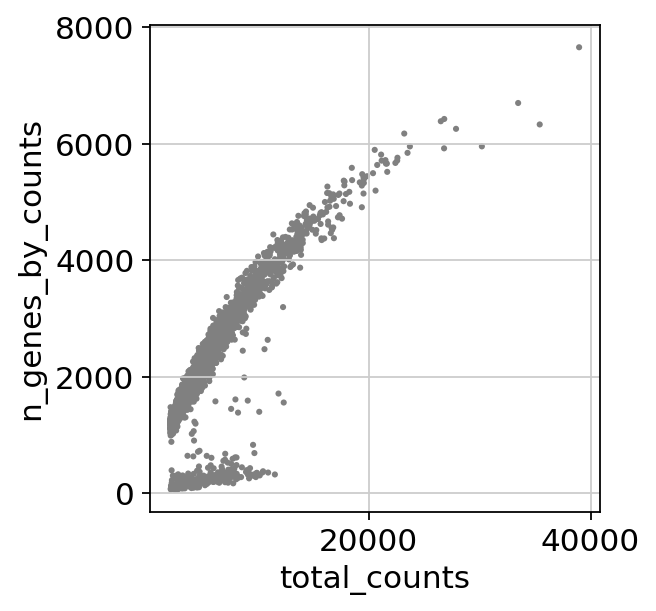

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Remove cells with too few genes per count

In [19]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

normalize and log data

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/rmandla/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


normalizing counts per cell
    finished (0:00:00)


Highly variable genes...

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


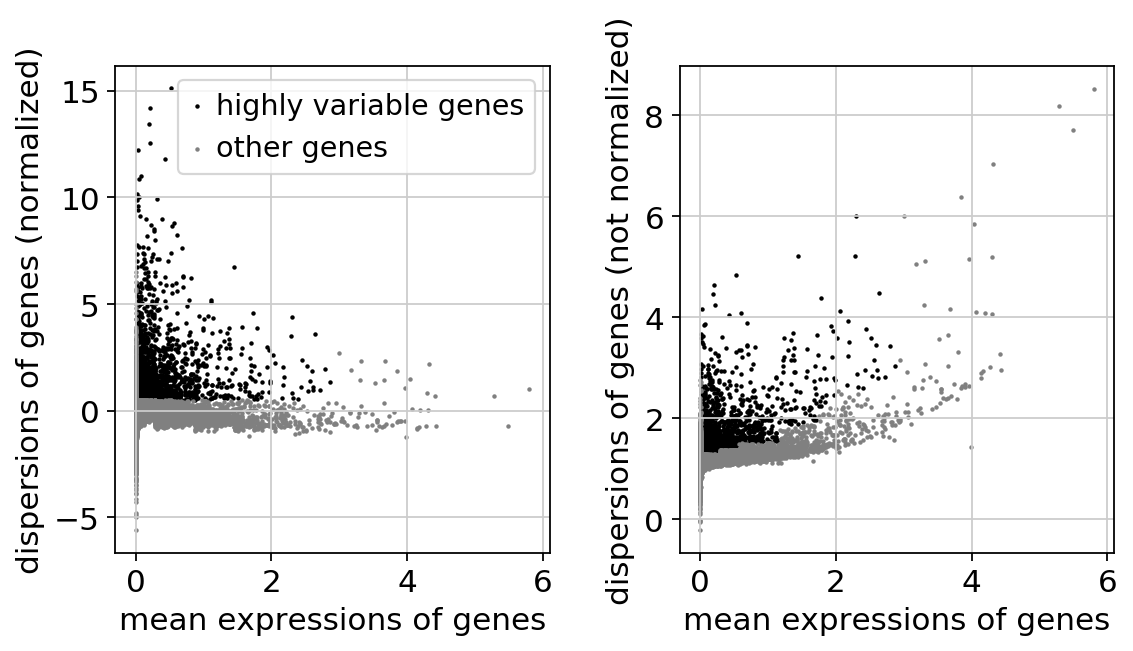

In [22]:
sc.pl.highly_variable_genes(adata)

Set raw value to normalized computed values

In [23]:
adata.raw = adata

Filter highly variable genes

In [24]:
adata = adata[:, adata.var.highly_variable]

regress out effects and scale to unit variance

In [25]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [26]:
sc.pp.scale(adata, max_value=10)

## PCA

In [27]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [28]:
adata

AnnData object with n_obs × n_vars = 2916 × 2102
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

color for myh6

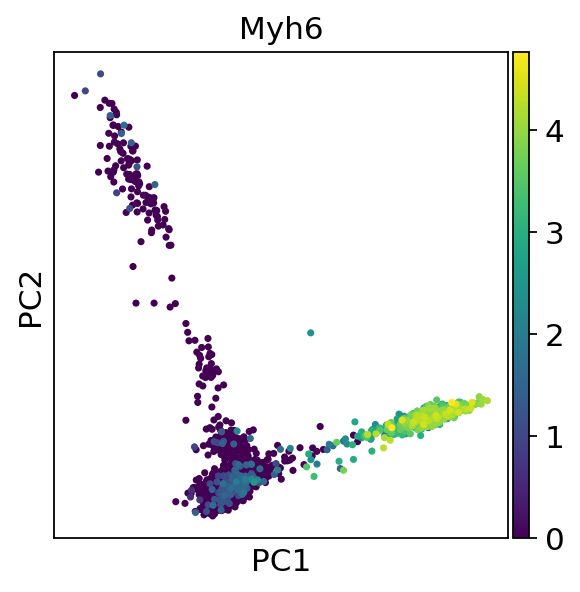

In [29]:
sc.pl.pca(adata, color='Myh6')

Effects of pca analysis...

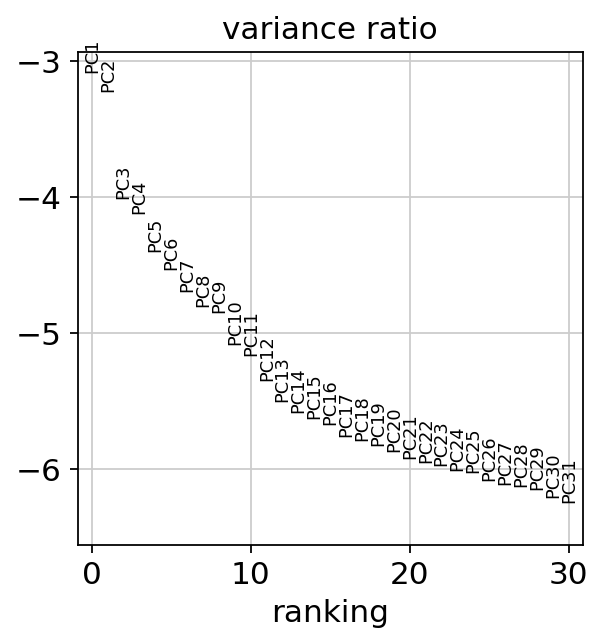

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

Save data

In [31]:
adata.write(results_file)

In [32]:
adata

AnnData object with n_obs × n_vars = 2916 × 2102
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

generate neighbor calculation. using default values in tutorial for now

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


Using umap instead of tsne...

In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


Generate umap with myh6, hcn4, and isl1

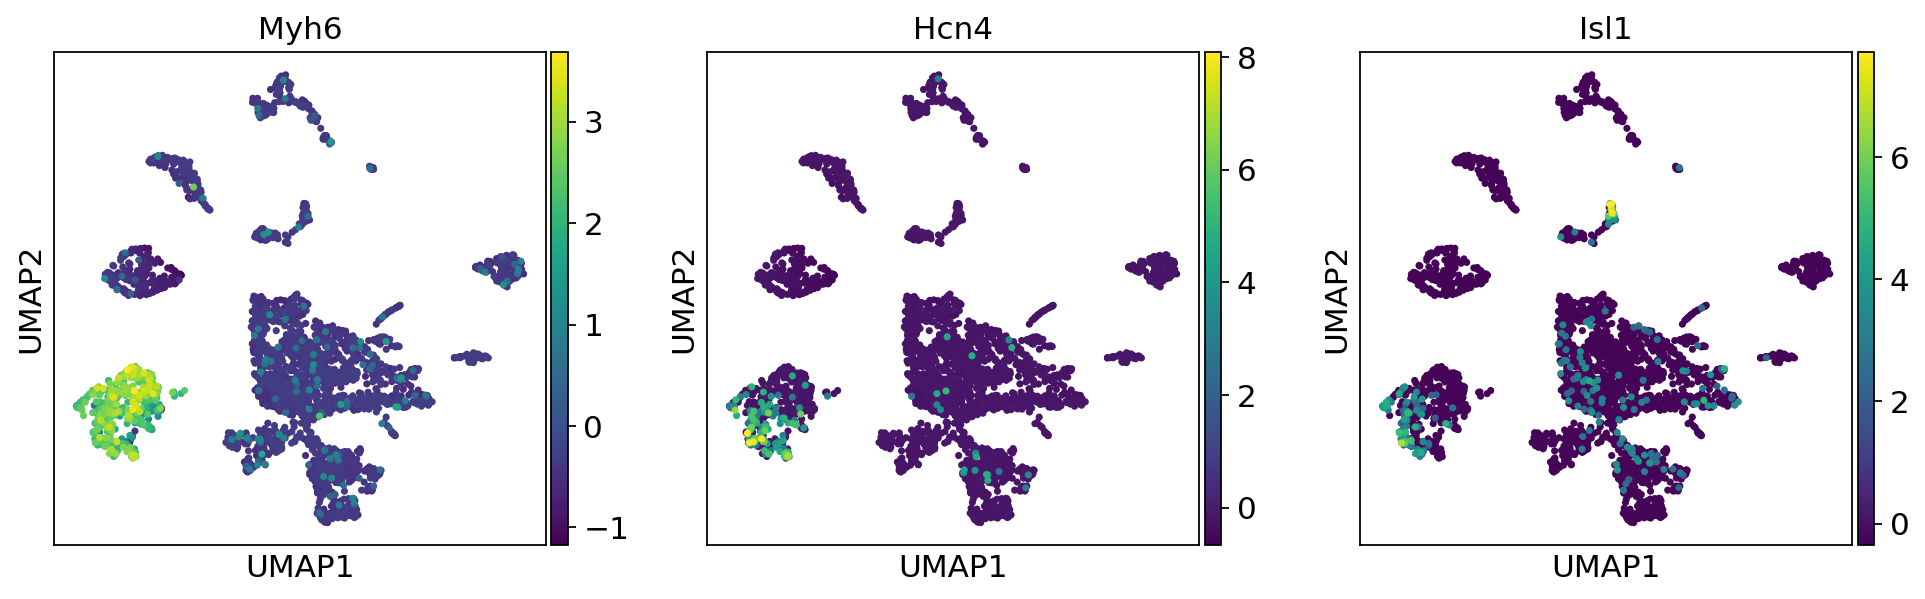

In [35]:
sc.pl.umap(adata, color=['Myh6', 'Hcn4', 'Isl1'],use_raw=False)

Clustering analysis

In [36]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


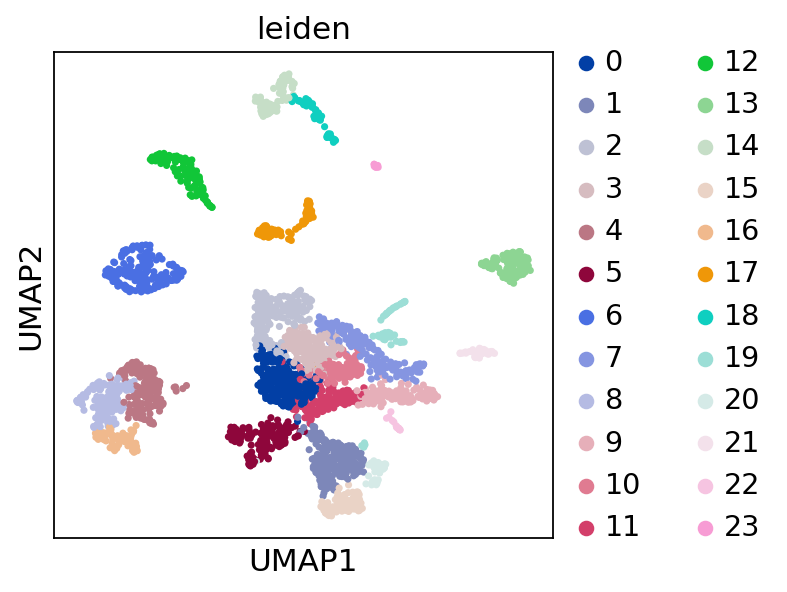

In [37]:
sc.pl.umap(adata, color=['leiden'])

Lots of clusters!

Highly differential genes per cluster

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


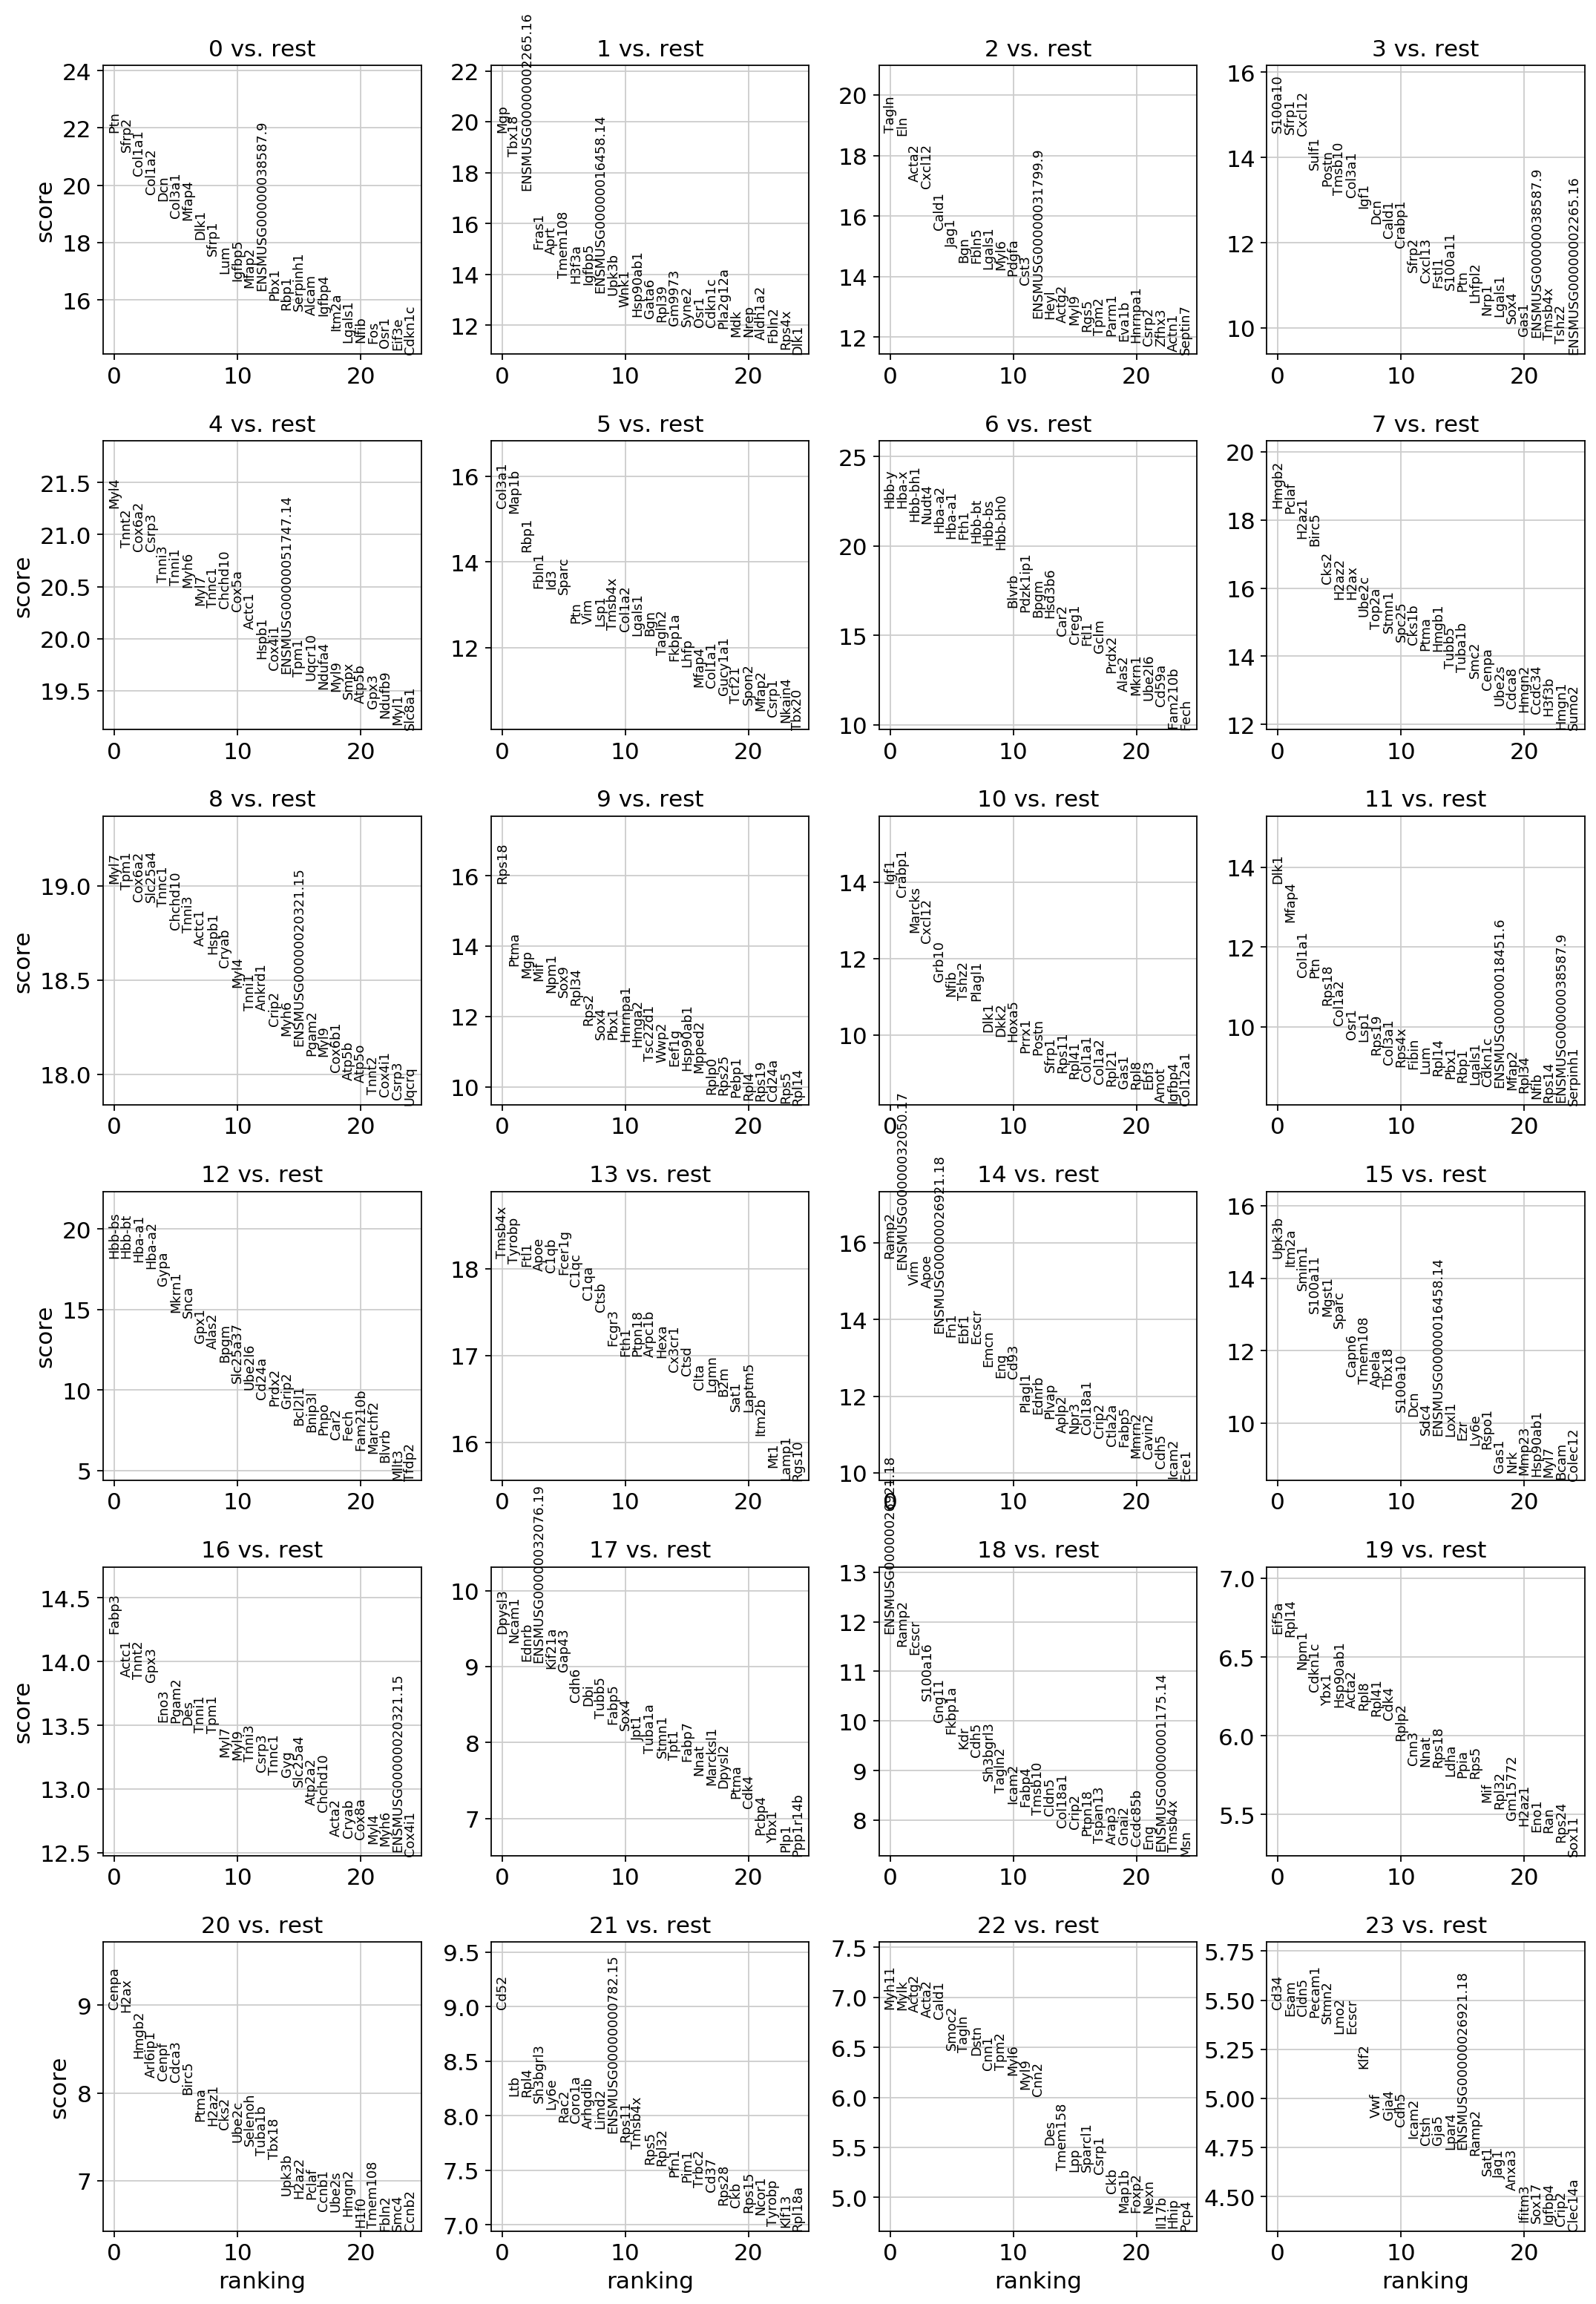

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

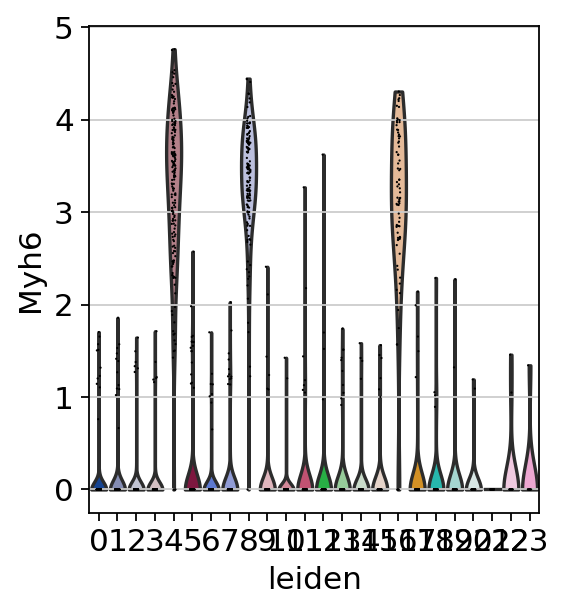

In [40]:
sc.pl.violin(adata, ['Myh6'], groupby='leiden')

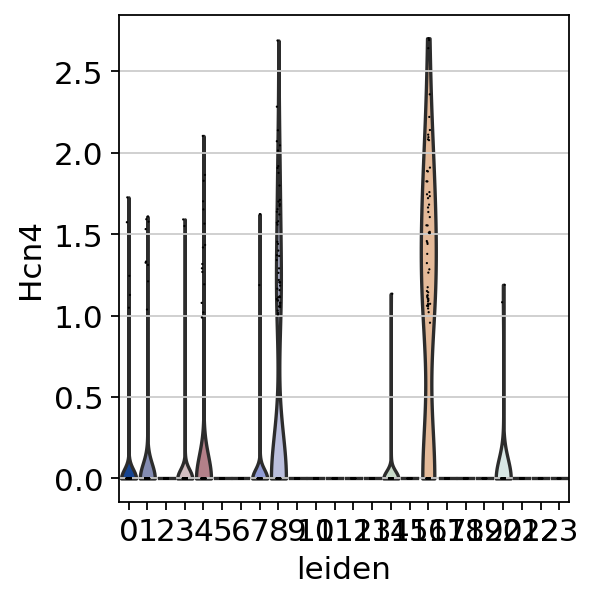

In [41]:
sc.pl.violin(adata, ['Hcn4'], groupby='leiden')

In [42]:
adata.write(results_file, compression='gzip')